## Regulization
- To penalize the weight to be smaller
- By penalizing the weights, the performance of the model increases

### 1. L1 Regulization
#### L1
- Add a Norm of the absolute value of the sume of the weights on Loss Function

    $\therefore ||w||_1 = \sum\limits_{i=1}^{n}|w_i|$  , where $n$ = number of weights 
- L1 Norm is multiplied by $\alpha$, which adjusts a strength level of the regulization

    $\therefore $ L1 Norm $= \alpha\sum\limits_{i=1}^{n} |w_i|$

- Therefore,

    $ \therefore L = -(y\log(a) + (1-y)\log(1-a)) + \alpha\sum\limits_{i=1}^{n}|w_i| $

    - Since $\alpha$ is greater so that $w$ gets smaller, then but the value of $L$ does not get bigger
    - Since $\alpha$ is smaller so that $w$ gets bigger, then but the value of $L$ does not get bigger 
  
  
#### Derivative of L1 Regulization
    
- $\therefore \frac{\partial L}{\partial w} = \frac{\partial}{\partial w}[-(y\log(a)+(1-y)\log(1-a)) + \alpha\sum\limits_{n=1}^{n}|w_i|]$

- $\therefore \frac{\partial L}{\partial w} =  -(y-a)x + \alpha  sign(w)$

    _where *sign(w)* = derivatives of *|w|*, which outputs the sign of (+) or (-)_

                         
#### Weights Update
    
- $\therefore w = w - \eta \frac{\partial L}{\partial w}$
- $\therefore w = w + \eta ((y-a)x - \alpha  sign(w))$
    
    _where $\eta$ = learning rate_

   
#### Note

- In python, **w_grad += alpha * np.sign(w)**

- No Regulization on Bias: 
    - Bias only shifts the model, but no impact on complexity
- In Regression, by adding a L1 penalty, you can create a Lasso Model
    - $\therefore$ Lasso makes some weights as zero
    - $\therefore$ Zero weights eliminate the features
- As seen in the derivatives, L1 highly depends on $\alpha$



### 2. L2 Regulization
#### L2
- Add a Norm of the squared root of the sum of the weights squares
        
    $\therefore ||w||_2 = \sqrt{\sum\limits_{i=1}^{n}|w_i|^2}$
- L2 Norm is multiplied by $\alpha$ for the penalty level and $\frac{1}{2}$ to output a better look for differentiation
        
    $\therefore ||w||_2 = \frac{1}{2} \alpha \sum\limits_{i=1}^{n} |w_i|^2$
        
- Therefore,
    
    $ \therefore L = -(y\log(a) + (1-y)\log(1-a)) + \frac{1}{2} \alpha \sum\limits_{i=1}^{n} |w_i|^2$

#### Derivative of L2 Regulization
    
- $\therefore \frac{\partial L}{\partial w} = \frac{\partial}{\partial w}[-(y\log(a)+(1-y)\log(1-a)) + \frac{1}{2} \alpha \sum\limits_{i=1}^{n} |w_i|^2]$

- $\therefore \frac{\partial L}{\partial w} =  -(y-a)x + \alpha w$

#### Weights Update
    
- $\therefore w = w - \eta \frac{\partial L}{\partial w}$
- $\therefore w = w + \eta (y-a)x -\alpha w$

    _where $\eta$ = learning rate_
    
#### Note

- In python, **w_grad += alpha * w**

- L2 is more efficient since the value of $w$ is acutually computed
- In Regression, by adding a L2 penalty, you can create a Ridge Model
    - $\therefore$ Ridge makes weights close to zero, but not zero


### 3. SingleLayer_Reg Class

In [1]:
class SingleLayer_Reg:
    def __init__(self, learning_rate = 0.1, l1 = 0, l2 = 0):
        self.w = None
        self.b = None
        self.loss = []
        self.val_loss = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        
    def fwrd(self, x):
        z = np.sum(x * self.w) + self.b
        return z
    
    def activation(self, z):
        a = 1 / (1 + np.exp(-z))
        return a
    
    def bwrd(self, x, err):
        w_grad = x * err
        b_grad = 1 * err
        return w_grad, b_grad
    
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2/2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.fwrd(x_val[i])
            a = self.activation(z)
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a) + (1-y_val[i])*np.log(1-a))
        self.val_loss.append(val_loss/len(y_val) + self.reg_loss())
        
    def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy())
        np.random.seed(42)
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:
                z = self.fwrd(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.bwrd(x[i], err)
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
                self.w -= self.lr * w_grad
                self.b -= b_grad
                self.w_history.append(self.w.copy())
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += - (y[i]*np.log(a) + (1-y[i])*np.log(1-a))
            self.loss.append(loss/len(y) + self.reg_loss())
            self.update_val_loss(x_val, y_val)
            
    def predict(self, x):
        z = [self.fwrd(xi) for xi in x]
        return np.array(z) > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x)==y)

### 4. Load the data

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify = y, 
                                                            test_size = 0.2, random_state = 42)
print(x_train_all.shape, x_test.shape, y_train_all.shape, y_test.shape)

(455, 30) (114, 30) (455,) (114,)


In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all,
                                                  test_size = 0.2, random_state = 42)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(364, 30) (91, 30) (364,) (91,)


### 5. Scaling

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

### 6. L1 penalty

#### 6-1. Train_loss vs Validation_loss Check 

- As Learning Rate gets bigger, Loss from both Train-set and Valid-set gets higher.
    - Thus, Under-Fitting
- As L1 gets bigger, the weights close to 0

- To sum up, Hyper-parameter of L1 should be 0.001


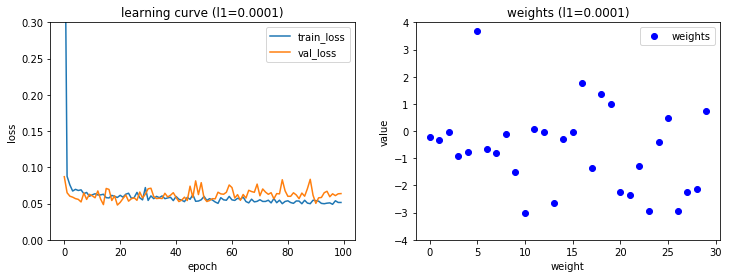

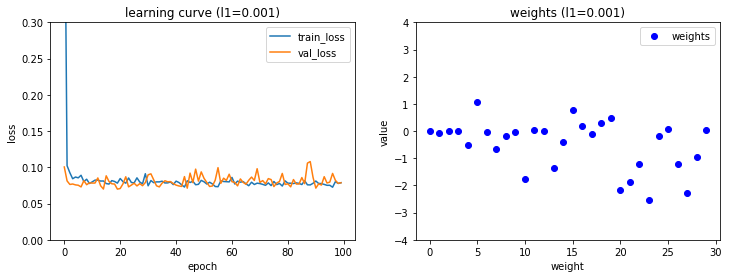

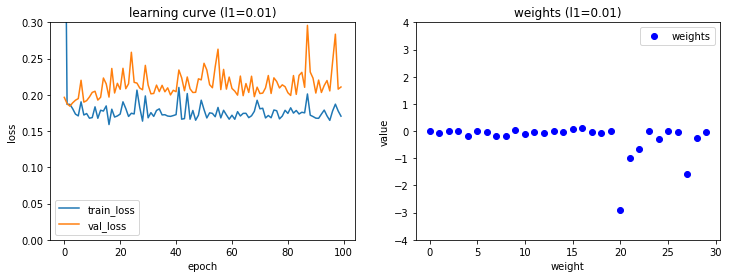

In [5]:
l1_lst = [0.0001, 0.001, 0.01]
for i in l1_lst:
    lyr = SingleLayer_Reg(l1=i)
    lyr.fit(x_train_scaled, y_train, x_val= x_val_scaled, y_val = y_val)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 4))
    
    ax1.plot(lyr.loss)
    ax1.plot(lyr.val_loss)
    ax1.set_title('learning curve (l1={})'.format(i))
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend(['train_loss', 'val_loss'])
    ax1.set_ylim(0,0.3)
    
    ax2.plot(lyr.w, 'bo')
    ax2.set_title('weights (l1={})'.format(i))
    ax2.set_ylim(-4,4)
    ax2.set_xlabel('weight')
    ax2.set_ylabel('value')
    ax2.legend(['weights'])
    plt.show()

#### 6-2. Performance of the model

In [6]:
lyr1 = SingleLayer_Reg(l1 = 0.001)
lyr1.fit(x_train_scaled, y_train, epochs = 20)
round(lyr1.score(x_val_scaled, y_val),3)

0.978

### 7. L2 Penalty

#### 7-1. Train_loss vs Validation_loss Check 

- Similar Pattern to L1 Penalty
- However, Last graph shows that as L2 penalty gets stronger, Under-Fitting has happened
- To sum up, Hyper-parameter of L1 should be 0.01 with epoch of 50


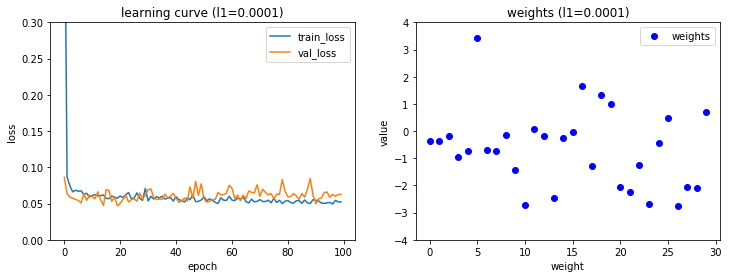

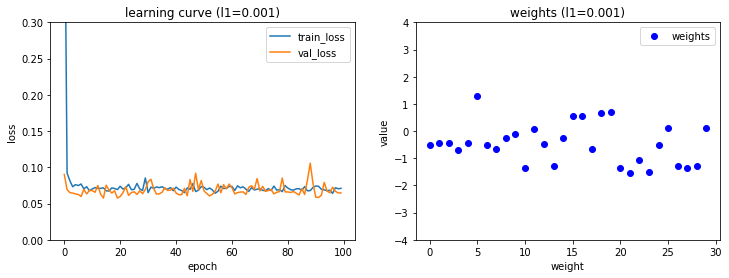

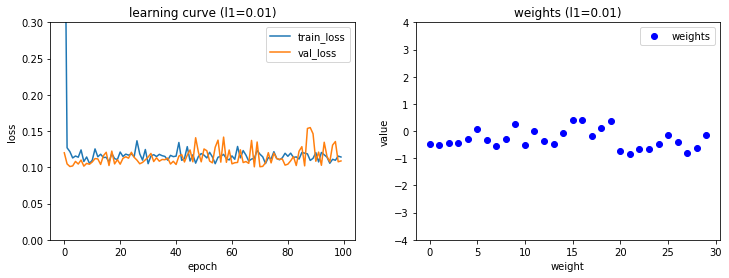

In [7]:
l2_lst = [0.0001, 0.001, 0.01]
for i in l2_lst:
    lyr = SingleLayer_Reg(l2=i)
    lyr.fit(x_train_scaled, y_train, x_val= x_val_scaled, y_val = y_val)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 4))
    
    ax1.plot(lyr.loss)
    ax1.plot(lyr.val_loss)
    ax1.set_title('learning curve (l1={})'.format(i))
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend(['train_loss', 'val_loss'])
    ax1.set_ylim(0,0.3)
    
    ax2.plot(lyr.w, 'bo')
    ax2.set_title('weights (l1={})'.format(i))
    ax2.set_ylim(-4,4)
    ax2.set_xlabel('weight')
    ax2.set_ylabel('value')
    ax2.legend(['weights'])
    plt.show()

#### 7-2. Performance of the model
- The same as L1

In [8]:
lyr2 = SingleLayer_Reg(l2 = 0.01)
lyr2.fit(x_train_scaled, y_train, epochs = 50)
round(lyr2.score(x_val_scaled, y_val),3)

0.978

### 8. Using sklearn to compare with

#### 8-1. L1 Penalty with 0.001

In [9]:
from sklearn.linear_model import SGDClassifier
sgd1 = SGDClassifier(loss = 'log', penalty = 'l1', alpha = 0.001, random_state = 42)
sgd1.fit(x_train_scaled, y_train)
round(sgd1.score(x_val_scaled, y_val),3)

0.967

#### 8-2. L2 Penalty with 0.01

In [10]:
sgd2 = SGDClassifier(loss = 'log', penalty = 'l2', alpha = 0.01, random_state = 42)
sgd2.fit(x_train_scaled, y_train)
round(sgd2.score(x_val_scaled, y_val),3)

0.978